The IPSuite package is designed to build computational workflows which are executed at a later time.
Whilst this becomes extremly helpful, it is always a good start to learn the package in `eager` or direkt mode.
Some Nodes might produce outputs files, so please be aware that your workspace might be affected.

In [1]:
import os  # environment variables for GAP Model
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import ipsuite as ips

2023-04-10 22:52:24,310 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [3]:
with ips.Project(automatic_node_names=True) as project:
    data = ips.AddData(file="KCl1650K.extxyz", lines_to_read=100)
    random_selection = ips.configuration_selection.RandomSelection(
        data=data, n_configurations=5
    )
    uniform_selection = ips.configuration_selection.UniformEnergeticSelection(
        data=data,
        n_configurations=10,
        exclude_configurations=random_selection.exclude_configurations,
    )
project.run(eager=True, save=False)


Reading File: 100it [00:00, 242.14it/s]


2023-04-10 22:52:25,103 (DEBUG): Selecting from 100 configurations.
2023-04-10 22:52:25,105 (DEBUG): Selecting from 100 configurations.
2023-04-10 22:52:25,106 (WARNING): Running search for 10 to max 100


In [4]:
random_selection.selected_configurations

{'AddData': [35, 40, 61, 81, 98]}

In [5]:
uniform_selection.selected_configurations

{'AddData': [0, 12, 18, 22, 26, 30, 34, 38, 44, 99]}

We can now train a GAP model on the given data.

Reading File: 100it [00:00, 285.21it/s]


2023-04-10 22:52:26,680 (DEBUG): Selecting from 100 configurations.
2023-04-10 22:52:26,681 (DEBUG): Selecting from 100 configurations.
2023-04-10 22:52:26,682 (WARNING): Running search for 10 to max 100
2023-04-10 22:52:26,691 (INFO): ---- Writing the GAP input file ----


/data/fzills/miniconda3/envs/ipsuite/lib/python3.10/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


2023-04-10 22:52:26,696 (INFO): --- Training model ---


100%|█████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


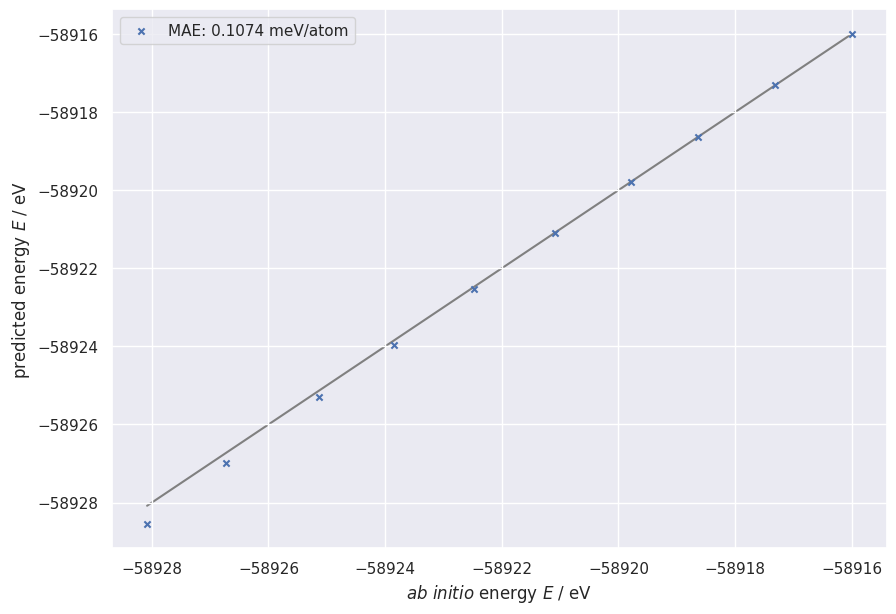

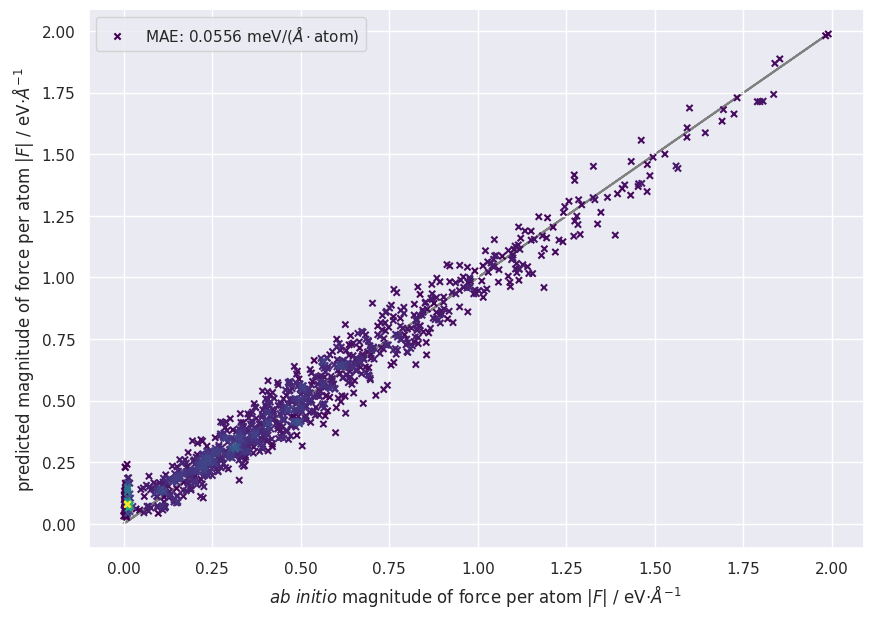

In [6]:
with project:
    model = ips.models.GAP(data=random_selection)
    prediction = ips.analysis.Prediction(model=model, data=uniform_selection)
    analyse = ips.analysis.PredictionMetrics(data=prediction)
project.run(eager=True, save=False)


In the next Tutorial you will learn how to use DVC to track your Experiments and save the results.